
# Exotic Option Pricing — European, Barrier, Lookback (avec explications)

Ce notebook s'appuie sur les modules suivants (dans le même dossier que ce notebook) :

- `aux_functions.py`
- `european_call.py`
- `barrier_call.py`
- `lookback_call.py`

Objectifs :

1. Comprendre les briques utilitaires (`aux_functions`).
2. Utiliser et expliquer :
   - `european_call_option`
   - `barrier_call_option`
   - `lookback_call_option`
3. Comparer les trois méthodes de pricing :
   - Formule **exacte** (si dispo)
   - **Monte Carlo**
   - **PDE Crank–Nicolson**

Tout est structuré pour pouvoir être relu par un correcteur / examinateur.


In [13]:
# Import des bibliothèques scientifiques et des classes de pricing maison
import numpy as np
import matplotlib.pyplot as plt

from european_call import european_call_option
from barrier_call import barrier_call_option
from lookback_call import lookback_call_option

# Style plotting homogène pour toutes les figures
plt.style.use("ggplot")



## 1. Fonctions utilitaires (`aux_functions.py`)

Le fichier `aux_functions.py` contient les briques communes utilisées par les 3 produits.

### 1.1. Mouvement brownien & GBM

- `wiener(t)`  
  Renvoie un tirage de \(W_t \sim \mathcal{N}(0, t)\).

- `st(t, S0, r, sigma)`  
  Donne la solution fermée du GBM :

\[
S_t = S_0 \exp\Big( (r - \tfrac{1}{2}\sigma^2)t + \sigma W_t \Big)
\]

C’est utilisé pour simuler directement \(S_T\) en Monte Carlo **sans** discrétiser en temps.

### 1.2. Solveurs tridiagonaux

Deux versions :

- `const_tri_diag_mat_solve(params, b)`  
  Pour une matrice tridiagonale à coefficients **constants** (`params = [p1, p2, p3]`).

- `tri_diag_mat_solve_arr(p1, p2, p3, b)`  
  Pour une matrice tridiagonale à coefficients variables (chaque diag est un array).

Ces fonctions implémentent l’algorithme de Thomas (forward + backward sweep).  
Elles servent dans les méthodes `price_pde` pour résoudre :

\[
A u^{n+1} = b
\]

à chaque pas de temps du schéma de Crank–Nicolson.

### 1.3. Interpolation linéaire

- `get_result(x_data, y_data, val)`  
  Permet, à partir de la solution PDE tabulée sur une grille `s`, d'obtenir la valeur au point `S0` par interpolation linéaire.

### 1.4. Fonctions pour formules fermées

- `delta_p(tau, s, r, sigma)`  
- `delta_m(tau, s, r, sigma)`  

Ces fonctions encodent les termes \(d_+\) / \(d_-\) généralisés pour s = ratio type \(S/K\) ou \(S/B\) etc., dans les formules analytiques (Black–Scholes, barrière, lookback Shreve).

- `cond_prob_M(B, k, T)`  

Probabilité conditionnelle :

\[
\mathbb{P}\big( \max_{0\le t\le T} W_t < B \,\big|\, W_T = k \big)
  = 1 - \exp\big( \tfrac{2B(k-B)}{T} \big)
\]

Utilisée dans le MC des options exotiques (barrière, lookback) pour corriger le payoff en fonction de la probabilité de ne pas avoir franchi la barrière / d’un maximum particulier, **sans simuler toute la trajectoire**.


In [14]:

# Paramètres de référence utilisés sur tous les exemples
S0    = 100.0
K     = 100.0
r     = 0.05
sigma = 0.2
T     = 1.0

print("Paramètres communs :")
print(f"S0 = {S0}, K = {K}, r = {r}, sigma = {sigma}, T = {T}")


Paramètres communs :
S0 = 100.0, K = 100.0, r = 0.05, sigma = 0.2, T = 1.0



## 2. European Call (`european_call_option`)

La classe `european_call_option` prend en entrée :

- `T, t` : maturité et temps courant,
- `S0` : spot,
- `K` : strike,
- `r` : taux,
- `sigma` : volatilité.

Elle propose 3 méthodes :

### 2.1. `price_exact()`

Utilise la formule fermée Black–Scholes :

\[
d_+ = \frac{\ln(S_0/K) + (r + \tfrac{1}{2}\sigma^2)\tau}{\sigma \sqrt{\tau}},
\quad
\ d_- = d_+ - \sigma\sqrt{\tau},
\]

\[
C = S_0 N(d_+) - K e^{-r\tau} N(d_-),
\quad \tau = T - t.
\]

### 2.2. `price_monte_carlo(n_iters)`

Boucle Monte Carlo :

1. Simule \(S_T\) avec `st(T, S0, r, sigma)`.
2. Calcule le payoff \(\max(S_T - K, 0)\).
3. Actualise par \(e^{-rT}\).
4. Moyenne.

### 2.3. `price_pde(n_t, n_s)`

Résout la PDE en variables transformées :

- \(\tau = \frac{\sigma^2}{2}(T - t)\),
- \(x = \log(S/K)\),

pour une fonction réduite \(u(\tau, x)\), puis revient à \(V(t,S)\) à la fin.

- Grille en `x` : de \(\log(K/3K) = \log(1/3)\) à \(\log(3K/K) = \log(3)\) → donc `S` de `K/3` à `3K`.
- Condition initiale (à \(\tau = 0\)) = payoff en variables réduites.
- Schéma Crank–Nicolson ⇒ à chaque pas :
  - construction du vecteur `b`,
  - résolution du système tridiagonal `A u^{n+1} = b`.

Ensuite :
- on multiplie par `x_data = exp(x)*K` pour revenir à V,
- on reconstruit `t` et `s` en variables originales,
- on stocke dans `self.pde_t, self.pde_s, self.pde_v`.

Enfin, `get_pde_result(S0)` interpole et renvoie \(V(0, S_0)\).


In [15]:

# 2.4. Utilisation concrète du pricing European call
ec = european_call_option(
    T=T,        # maturité contractuelle
    t=0.0,      # temps courant (pricing à t=0)
    S0=S0,      # spot initial
    K=K,        # strike at-the-money
    r=r,        # taux sans risque
    sigma=sigma # volatilité
)

# Prix exact (Black–Scholes)
price_exact_ec = ec.price_exact()

# Prix Monte Carlo (beaucoup d'itérations pour stabiliser la moyenne)
price_mc_ec = ec.price_monte_carlo(n_iters=100_000)

# Pré-calcul PDE : renvoie (t, s, v) sur la grille CN
# On stocke la solution pour ensuite interpoler la valeur au spot
_tec, s_ec, v_ec = ec.price_pde(n_t=200, n_s=200)
price_pde_ec = ec.get_pde_result()  # par défaut, interpole en S0 interne

print("=== European Call ===")
print(f"Exact        : {price_exact_ec:.6f}")
print(f"Monte Carlo  : {price_mc_ec:.6f}")
print(f"PDE (CN)     : {price_pde_ec:.6f}")


=== European Call ===
Exact        : 10.450584
Monte Carlo  : 10.540024
PDE (CN)     : 10.524539


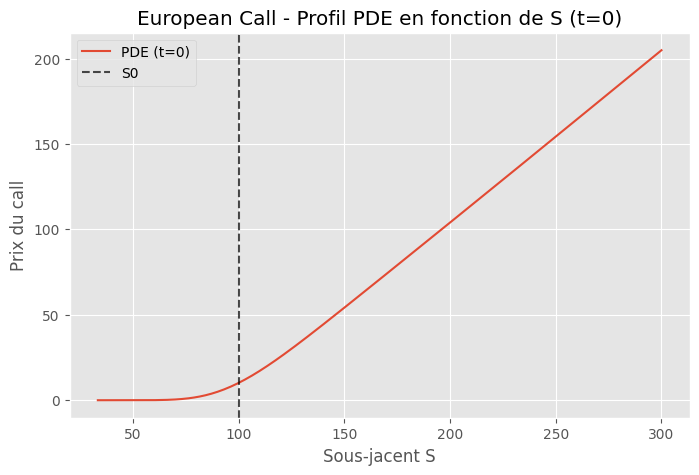

In [16]:

# Visualisation de la surface PDE (t=0) en fonction de S
plt.figure(figsize=(8, 5))
plt.plot(s_ec, v_ec[-1, :], label="PDE (t=0)")
plt.axvline(S0, color="k", linestyle="--", alpha=0.7, label="S0")
plt.title("European Call - Profil PDE en fonction de S (t=0)")
plt.xlabel("Sous-jacent S")
plt.ylabel("Prix du call")
plt.legend()
plt.grid(True)
plt.show()



## 3. Barrier up-and-out call (`barrier_call_option`)

Paramètres supplémentaires :

- barrière `B` (up-and-out).

Payoff :

- Si la trajectoire dépasse `B` à un moment dans `[0,T]` → **knock-out**, payoff = 0.
- Sinon, payoff = (S_T - K)^+.

### 3.1. `price_exact()`

Utilise la formule fermée pour le call barrière up-and-out (Shreve) :

- combinaison de termes de type call européen,
- plus/reflets à la barrière,
- via les fonctions `delta_p` / `delta_m` et des facteurs de type \((S_0/B)^{-2r/\sigma^2}\).

Le code :

```python
v = S0*(N(δ_p(S0/K)) - N(δ_p(S0/B)))
    - e^{-rτ}K*(N(δ_m(S0/K)) - N(δ_m(S0/B)))
    - B*(S0/B)^{-2r/σ^2}(N(δ_p(B^2/(KS0))) - N(δ_p(B/S0)))
    + e^{-rτ} K (S0/B)^{-2r/σ^2+1}(N(δ_m(B^2/(KS0))) - N(δ_m(B/S0)))
```

### 3.2. `price_monte_carlo(n_iters)`

Ici, MC est plus fin qu’un MC naïf :

1. On change de mesure : on simule un Wiener modifié `wiener_hat = W_T + aT`, avec
   \[
   a = \frac{r - \sigma^2/2}{\sigma}
   \]

2. On en déduit `S_T = S0 * exp(σ * wiener_hat)`.

3. Si `S_T > B`, c’est *forcément* knock-out, donc payoff = 0.

4. Sinon, on corrige par la probabilité que le **maximum** du Wiener soit resté sous le niveau `b = (1/σ) log(B/S0)` conditionnellement à `W_T = wiener_hat` :
   \[
   \mathbb{P}(\max W_t < b \mid W_T = wiener\_hat) = \text{cond\_prob\_M}(b, wiener\_hat, T)
   \]

   → `Indicator = cond_prob_M(...)` remplace le 1.

5. Payoff MC :
   \[
   e^{-rT} \max(S_T - K, 0) \times \text{Indicator}
   \]

C’est *bien plus propre* qu’un MC discretisé en temps avec probabilité d’overshoot.

### 3.3. `price_pde(n_t, n_s)`

Même logique que le call européen, mais domaine tronqué :

* `S ∈ [K/3, B]` (barrière = frontière de Dirichlet: u=0).

* Conditions aux frontières :

  * S proche de 0 → valeur ~ 0
  * S proche de B → u = 0 (knock-out)

Même Crank–Nicolson que pour le call européen, mais avec ces conditions aux bords.


In [17]:

# Paramètres spécifiques pour l'option barrière
B = 120.0  # barrière up-and-out

bc = barrier_call_option(
    T=T,
    t=0.0,
    S0=S0,
    K=90.0,
    B=B,
    r=r,
    sigma=0.25
)

# Trois méthodes de pricing
price_exact_bc = bc.price_exact()
price_mc_bc = bc.price_monte_carlo(n_iters=200_000)
_tbc, s_bc, v_bc = bc.price_pde(n_t=200, n_s=200)
price_pde_bc = bc.get_pde_result()

print("=== Barrier Up-and-Out Call ===")
print(f"Exact        : {price_exact_bc:.6f}")
print(f"Monte Carlo  : {price_mc_bc:.6f}")
print(f"PDE (CN)     : {price_pde_bc:.6f}")


=== Barrier Up-and-Out Call ===
Exact        : 2.267241
Monte Carlo  : 2.262053
PDE (CN)     : 2.133320


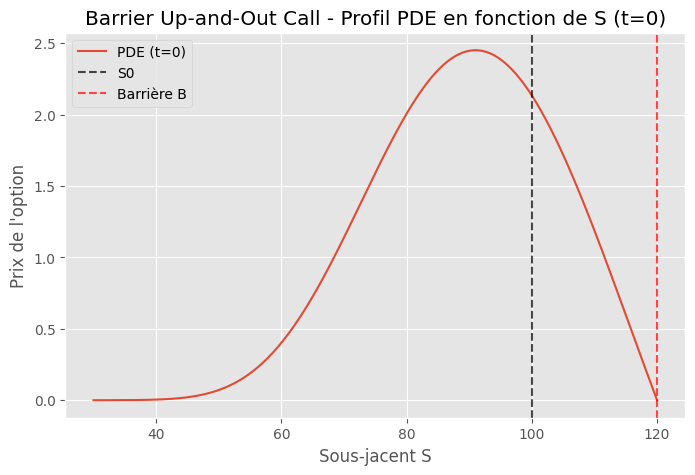

In [18]:

# Visualisation PDE pour l'option barrière
plt.figure(figsize=(8, 5))
plt.plot(s_bc, v_bc[-1, :], label="PDE (t=0)")
plt.axvline(S0, color="k", linestyle="--", alpha=0.7, label="S0")
plt.axvline(B,  color="r", linestyle="--", alpha=0.7, label="Barrière B")
plt.title("Barrier Up-and-Out Call - Profil PDE en fonction de S (t=0)")
plt.xlabel("Sous-jacent S")
plt.ylabel("Prix de l'option")
plt.legend()
plt.grid(True)
plt.show()



## 4. Lookback call à strike flottant (`lookback_call_option`)

Produit : **lookback floating strike call**.

Payoff :

\[
\text{Payoff} = e^{-rT} \left( \max_{0 \le t \le T} S_t - S_T \right)
\]

### 4.1. `price_monte_carlo(n_iters)`

Astuce : on ne simule **pas** toute la trajectoire, mais :

1. On génère `wiener_hat = W_T + aT` avec
   \[
   a = \frac{r - \sigma^2/2}{\sigma}
   \]

2. `ST = S0 * exp(σ * wiener_hat)`.

3. On génère la valeur du **maximum** de `W_t` conditionnellement à `W_T = wiener_hat` via un tirage inverse :
   \[
   M = \frac{1}{2}\left(
       wiener\_hat + \sqrt{wiener\_hat^2 - 2 T \log(U)}
   \right), \quad U \sim \mathcal{U}(0,1)
   \]

   (c’est ce que fait la ligne avec `MaxW`.)

4. `Y = S0 * exp(σ * MaxW)` est donc \( \max S_t \).

5. Payoff :
   \[
   e^{-rT} (Y - ST)
   \]

### 4.2. `price_exact(z=1)`

Formule fermée (Shreve) pour le lookback flottant.  
Ici \(z\) représente le rapport \(z = \frac{S_T}{M_T}\).  
Au temps 0, naturel : \(z=1\).

Formule implémentée :

\[
V_0 = S_0 \left[
 (1+p) z N(\delta_p(z)) 
 + e^{-r\tau} N(-\delta_m(z))
 - p e^{-r\tau} z^{1-p} N(-\delta_m(1/z))
 - z
\right]
\]

où \(p = \sigma^2 / (2r)\).

### 4.3. `price_pde(n_t, n_s)`

Car la dimension naturelle du problème est réduite à 1 en posant :

\[
z = \frac{S_t}{M_t} \in (0, 1].
\]

- Le domaine PDE est donc `z ∈ [1/n_x, 1]`.
- `x = log(z)` → `x ∈ [log(1/n_x), 0]`.
- Conditions aux bords :
  - `x = log(1/n_x)` → condition sur \(u\) liée au max très grand.
  - `x = 0` (z=1) → condition sur la dérivée (Neumann modifiée) pour capturer la relation à la frontière \(S_t = M_t\).

Crank–Nicolson sur `u(τ,x)`, puis conversion inverse en \(V(t,z)\), puis \(V(t,S)\).  
Enfin, `get_pde_result(z)` donne la valeur à un `z` donné (par défaut `z=1`, donc temps 0).


In [19]:

# Paramétrage et pricing de l'option lookback floating strike
lb = lookback_call_option(
    T=T,
    t=0.0,
    S0=S0,
    r=r,
    sigma=sigma
)

price_exact_lb = lb.price_exact()        # z=1 par défaut pour t=0
price_mc_lb = lb.price_monte_carlo(n_iters=300_000)

_tlb, s_lb, v_lb = lb.price_pde(n_t=200, n_s=200)
price_pde_lb = lb.get_pde_result()       # interpolation au bord z=1

print("=== Lookback Floating Strike Call ===")
print(f"Exact        : {price_exact_lb:.6f}")
print(f"Monte Carlo  : {price_mc_lb:.6f}")
print(f"PDE (CN)     : {price_pde_lb:.6f}")


=== Lookback Floating Strike Call ===
Exact        : 14.290568
Monte Carlo  : 14.306495
PDE (CN)     : 19.361510


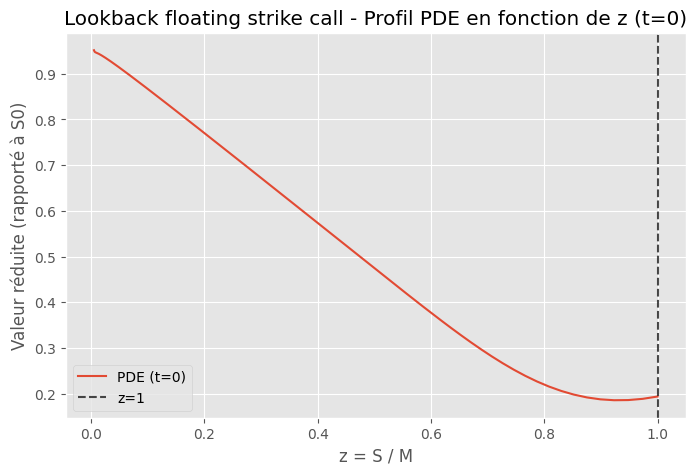

In [20]:

# Visualisation PDE pour le lookback (axe = z = S/M)
plt.figure(figsize=(8, 5))
plt.plot(s_lb, v_lb[-1, :], label="PDE (t=0)")
plt.axvline(1.0, color="k", linestyle="--", alpha=0.7, label="z=1")
plt.title("Lookback floating strike call - Profil PDE en fonction de z (t=0)")
plt.xlabel("z = S / M")
plt.ylabel("Valeur réduite (rapporté à S0)")
plt.legend()
plt.grid(True)
plt.show()


In [21]:

# Résumé global des trois produits
print("=== Résumé global ===")
print("European Call:")
print(f"  Exact       : {price_exact_ec:.6f}")
print(f"  Monte Carlo : {price_mc_ec:.6f}")
print(f"  PDE (CN)    : {price_pde_ec:.6f}")
print()
print("Barrier Up-and-Out Call:")
print(f"  Exact       : {price_exact_bc:.6f}")
print(f"  Monte Carlo : {price_mc_bc:.6f}")
print(f"  PDE (CN)    : {price_pde_bc:.6f}")
print()
print("Lookback Floating Strike Call:")
print(f"  Exact       : {price_exact_lb:.6f}")
print(f"  Monte Carlo : {price_mc_lb:.6f}")
print(f"  PDE (CN)    : {price_pde_lb:.6f}")


=== Résumé global ===
European Call:
  Exact       : 10.450584
  Monte Carlo : 10.540024
  PDE (CN)    : 10.524539

Barrier Up-and-Out Call:
  Exact       : 2.267241
  Monte Carlo : 2.262053
  PDE (CN)    : 2.133320

Lookback Floating Strike Call:
  Exact       : 14.290568
  Monte Carlo : 14.306495
  PDE (CN)    : 19.361510
